In [1]:
import zipfile
import os

# Path to the downloaded ZIP file
zip_file_path = "Green to Concrete Ratio.v1i.tfrecord.zip"
extraction_path = "dataset/"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Extraction completed. Files are now in the 'dataset/' folder.")

Extraction completed. Files are now in the 'dataset/' folder.


In [2]:
import os

# List the files in the extraction folder
print(os.listdir(extraction_path))

['README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


In [3]:
import os

# Check the subdirectories inside the train folder
train_dir = "dataset/train"
print("Classes in training folder:", os.listdir(train_dir))

valid_dir = "dataset/valid"
print("Classes in validation folder:", os.listdir(valid_dir))

test_dir = "dataset/test"
print("Classes in testing folder:", os.listdir(test_dir))

Classes in training folder: ['.ipynb_checkpoints', 'Buildings-Trees-Roads-Water.tfrecord', 'Buildings-Trees-Roads-Water_label_map.pbtxt']
Classes in validation folder: ['Buildings-Trees-Roads-Water.tfrecord', 'Buildings-Trees-Roads-Water_label_map.pbtxt']
Classes in testing folder: ['Buildings-Trees-Roads-Water.tfrecord', 'Buildings-Trees-Roads-Water_label_map.pbtxt']


In [29]:
import tensorflow as tf

def load_label_map(label_map_path):
    label_map = {}
    id_value = None  # Initialize id_value to avoid UnboundLocalError
    with open(label_map_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if "id" in line:
                # Strip the line to remove any commas or spaces
                id_value = int(line.split(":")[1].strip().replace(",", ""))
            elif "name" in line and id_value is not None:
                name_value = line.split(":")[1].strip().replace("\"", "")
                label_map[id_value] = name_value
                id_value = None  # Reset id_value after using it
    return label_map

# Load the label map
label_map_path = "dataset/train/Buildings-Trees-Roads-Water_label_map.pbtxt"
label_map = load_label_map(label_map_path)
print("Loaded label map:", label_map)

Loaded label map: {1: 'Building', 2: 'Main_image', 3: 'Road'}


In [20]:
import tensorflow as tf
import numpy as np

n =5  # Number of iterations you want to stop at
data = np.empty(shape=[0, 1], dtype=int)  # Initialize an empty array with shape (0, 1)

# Open and iterate over the TFRecord
raw_dataset = tf.data.TFRecordDataset("dataset/train/Buildings-Trees-Roads-Water.tfrecord")
print(raw_dataset)
for i, serialized_example in enumerate(raw_dataset):
    if i >= n:
        break  # Stop after n iterations

    # Parse the TFRecord example
    example = tf.train.Example()
    example.ParseFromString(serialized_example.numpy())  # Deserialize the example

    # Access the features (adjust the keys based on the inspection)
    Labels = example.features.feature['image/object/class/label'].int64_list.value  # Adjust the key here

    # Resize the data array and append the label
    data = np.vstack([data, [Labels[0]]])

print("Extracted Data:", data)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Extracted Data: [[2]
 [2]
 [1]
 [1]
 [2]]


In [18]:
import tensorflow as tf
import numpy as np

n = 5 # Number of iterations to extract
data = []  # List to store extracted image data and labels

# Open and iterate over the TFRecord
raw_dataset = tf.data.TFRecordDataset("dataset/train/Buildings-Trees-Roads-Water.tfrecord")

for i, serialized_example in enumerate(raw_dataset):
    if i >= n:
        break  # Stop after n iterations

    # Parse the TFRecord example
    example = tf.train.Example()
    example.ParseFromString(serialized_example.numpy())

    # Extract features (adjust keys if necessary based on inspection)
    labels = example.features.feature['image/object/class/label'].int64_list.value  # Extract label
    image_bytes = example.features.feature['image/encoded'].bytes_list.value[0]    # Extract image bytes

    # Decode the image
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    
    # Store the decoded image and label
    data.append((image.numpy(), labels[0]))

# Display the extracted data
for idx, (img, lbl) in enumerate(data):
    print(f"Image {idx + 1}: Shape = {img.shape}, Label = {lbl}")

Image 1: Shape = (640, 640, 3), Label = 2
Image 2: Shape = (640, 640, 3), Label = 2
Image 3: Shape = (640, 640, 3), Label = 1
Image 4: Shape = (640, 640, 3), Label = 1
Image 5: Shape = (640, 640, 3), Label = 2


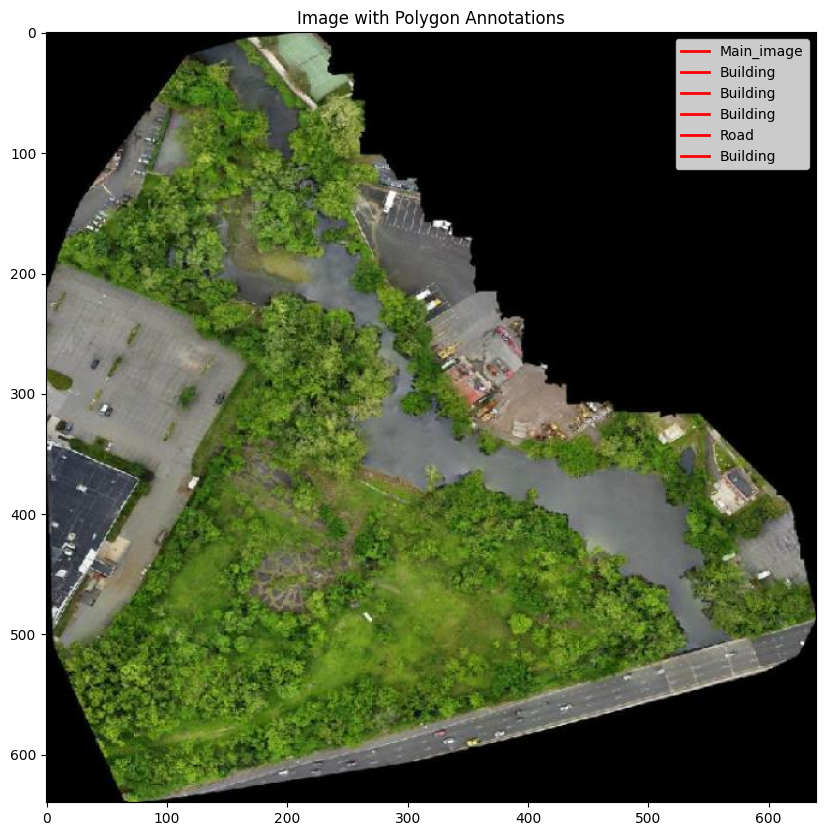

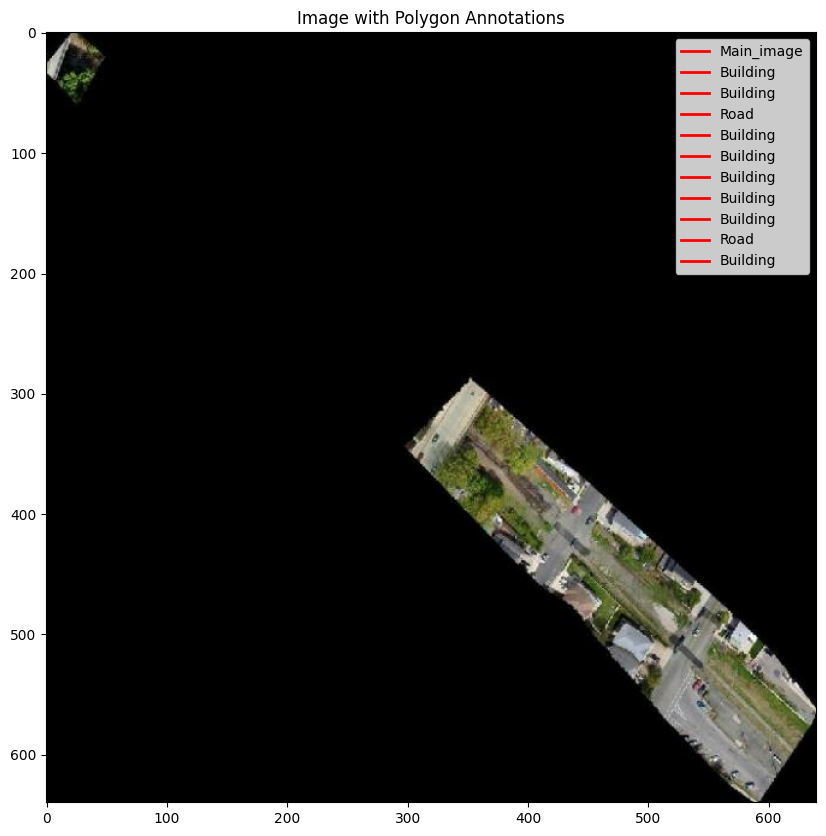

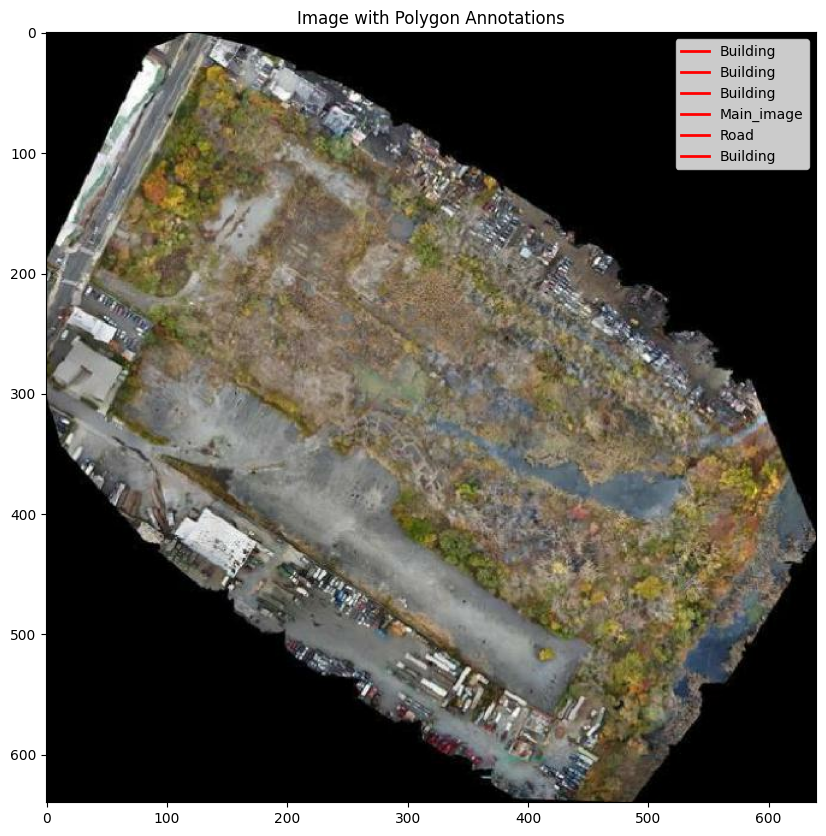

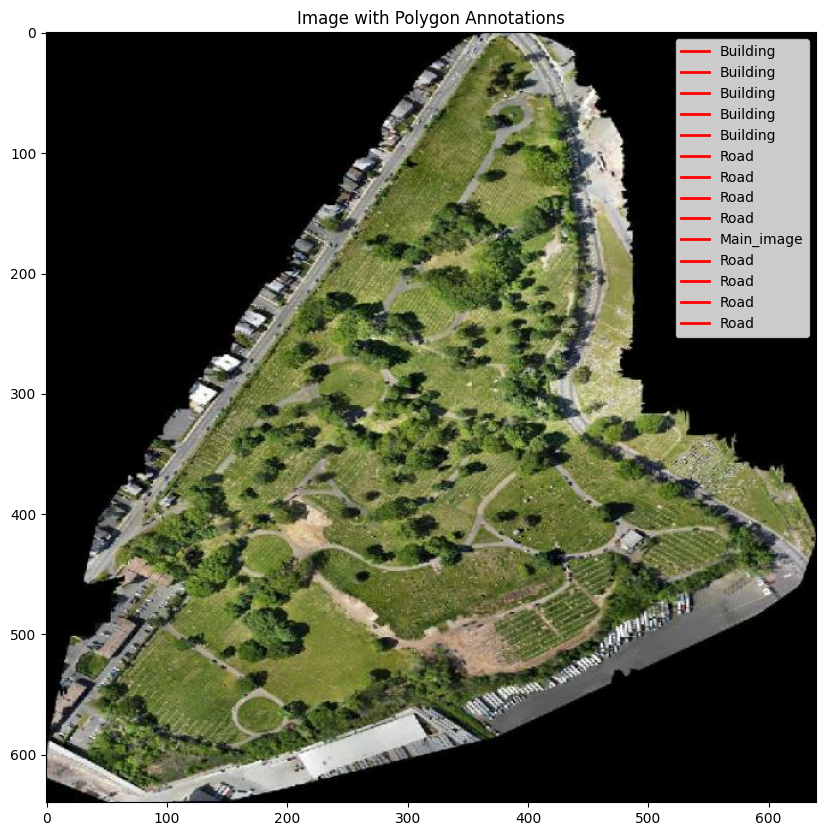

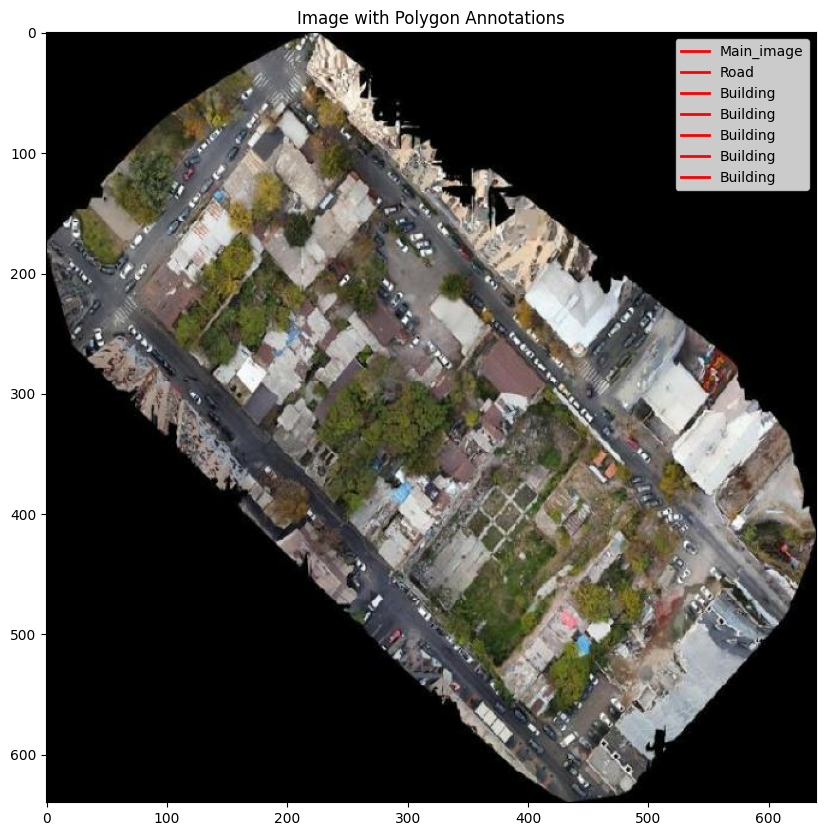

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to parse a single TFRecord example
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),  # Label names
        'image/object/polygon/points': tf.io.VarLenFeature(tf.float32),  # Polygon points
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode the image
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)

    # Extract label names and polygon points as tensors
    label_names = tf.sparse.to_dense(parsed_example['image/object/class/text'], default_value=b"")
    polygon_points = tf.sparse.to_dense(parsed_example['image/object/polygon/points'])

    return image, label_names, polygon_points

# Load the TFRecord file
tfrecord_path = "dataset/train/Buildings-Trees-Roads-Water.tfrecord"
dataset = tf.data.TFRecordDataset([tfrecord_path])
dataset = dataset.map(parse_tfrecord_fn)

# Function to visualize an image with polygon boundaries
def visualize_image_with_polygons(image, label_names, polygon_points):
    image = image.numpy()
    label_names = [label.decode("utf-8") for label in label_names.numpy()]
    polygon_points = polygon_points.numpy().reshape(-1, 2)  # Reshape points to (N, 2) for (x, y) coordinates

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Loop through polygons and plot each boundary
    for i, label in enumerate(label_names):
        x_coords = polygon_points[i * len(polygon_points) // len(label_names): (i + 1) * len(polygon_points) // len(label_names), 0]
        y_coords = polygon_points[i * len(polygon_points) // len(label_names): (i + 1) * len(polygon_points) // len(label_names), 1]

        plt.plot(x_coords, y_coords, color='red', linewidth=2, label=label)

    plt.legend()
    plt.title("Image with Polygon Annotations")
    plt.show()

# Iterate through the dataset and visualize
for image, label_names, polygon_points in dataset.take(5):
    visualize_image_with_polygons(image, label_names, polygon_points)

In [30]:
import tensorflow as tf

# Dataset parsing function
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/polygon/points': tf.io.VarLenFeature(tf.float32),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, [256, 256]) / 255.0  # Normalize the image

    # Create a binary mask for segmentation based on polygon points (simplified)
    mask = tf.zeros([256, 256, 1], dtype=tf.float32)  # Placeholder mask (to be improved with polygon drawing logic)

    return image, mask

# Create the dataset
tfrecord_path = "dataset/train/Buildings-Trees-Roads-Water.tfrecord"
dataset = tf.data.TFRecordDataset([tfrecord_path])
dataset = dataset.map(parse_tfrecord_fn)
dataset = dataset.shuffle(buffer_size=100).batch(16).prefetch(tf.data.AUTOTUNE)

# Split the dataset into training and validation sets
train_dataset = dataset.take(80)  # Assuming 80% for training
val_dataset = dataset.skip(80)

print("Dataset is ready for training.")

Dataset is ready for training.


In [31]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Downsampling
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upsampling
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    concat1 = layers.concatenate([up1, conv2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    concat2 = layers.concatenate([up2, conv1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_30[0][0]']              
                                )                                                           

In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    callbacks=callbacks)

print("Training complete. Model saved as 'unet_model.h5'.")

Epoch 1/50
      2/Unknown - 62s 24s/step - loss: 0.6593 - accuracy: 0.7448WARNING:tensorflow:Can save best model only with val_loss available, skipping.
2/2 [==============================] - 63s 25s/step - loss: 0.6593 - accuracy: 0.7448
Epoch 2/50
2/2 [==============================] - 54s 23s/step - loss: 0.3218 - accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - 54s 24s/step - loss: 0.0317 - accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 61s 29s/step - loss: 1.4107e-06 - accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 66s 23s/step - loss: 2.4589e-18 - accuracy: 1.0000
Epoch 6/50
2/2 [==============================] - 53s 23s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/50
2/2 [==============================] - 52s 22s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/50
2/2 [==============================] - 52s 22s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/50
2/2 [==============================] - 53s 23s/ste

In [32]:
import tensorflow as tf
import os

# Dataset parsing function
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/polygon/points': tf.io.VarLenFeature(tf.float32),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, [256, 256]) / 255.0  # Normalize the image

    # Create a binary mask for segmentation based on polygon points (simplified)
    mask = tf.zeros([256, 256, 1], dtype=tf.float32)  # Placeholder mask (to be improved with polygon drawing logic)

    return image, mask

# Function to load dataset from a folder of TFRecord files
def load_tfrecord_dataset(tfrecord_folder):
    tfrecord_files = [os.path.join(tfrecord_folder, fname) for fname in os.listdir(tfrecord_folder) if fname.endswith('.tfrecord')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord_fn)
    dataset = dataset.shuffle(buffer_size=100).batch(16).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load the training and validation datasets from their respective folders
train_dataset = load_tfrecord_dataset("dataset/train")
val_dataset = load_tfrecord_dataset("dataset/valid")

print("Training and validation datasets are ready for training.")

# Now you can proceed with model training:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min', verbose=1)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

print("Training complete. Model saved as 'unet_model.h5'.")

Training and validation datasets are ready for training.
Epoch 1/50
      2/Unknown - 68s 24s/step - loss: 0.6459 - accuracy: 0.9581
Epoch 1: val_loss improved from inf to 0.41505, saving model to unet_model.h5
2/2 [==============================] - 71s 28s/step - loss: 0.6459 - accuracy: 0.9581 - val_loss: 0.4150 - val_accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 1.0000 
Epoch 2: val_loss improved from 0.41505 to 0.04431, saving model to unet_model.h5
2/2 [==============================] - 66s 34s/step - loss: 0.2830 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 1.0000 
Epoch 3: val_loss improved from 0.04431 to 0.00000, saving model to unet_model.h5
2/2 [==============================] - 56s 25s/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 2.1332e-06 - val_accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - E

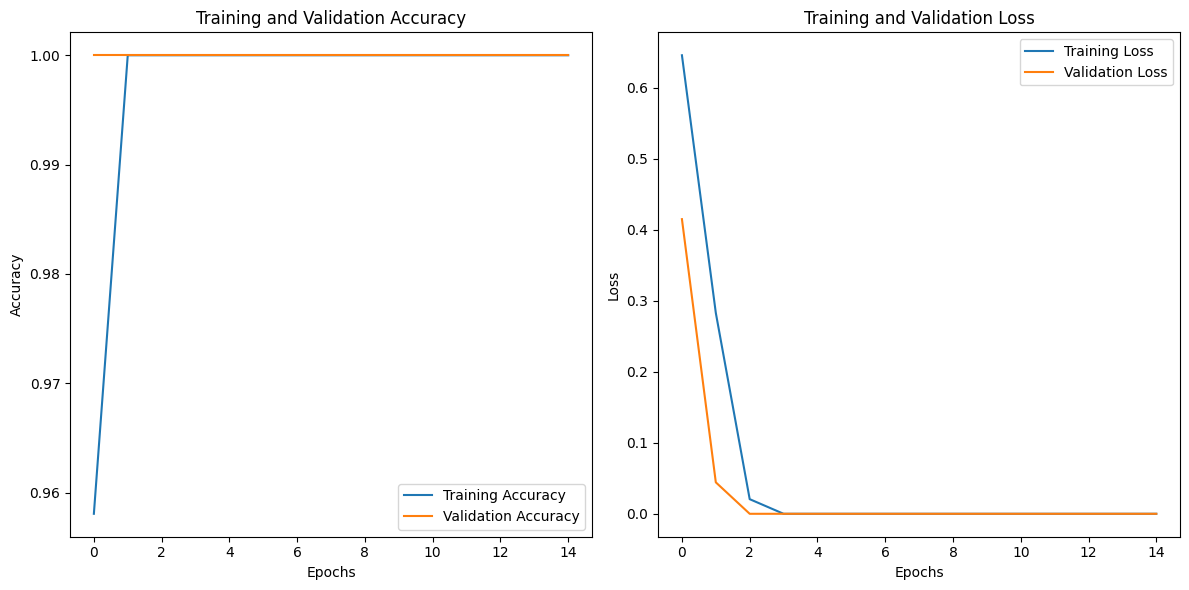

In [33]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()